In [2]:
from joblib import dump, load
import numpy as np
import cv2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
#import the clustered ds swatches
hsv_knn = load('ds_h_knn_3.joblib')

# Validation steps
1. import an image made from five swatches of ds paints
2. collect the hsv and shifted HSV values
3. Drop the neutral tones
4. Cluster on K-means++ and collect the top 5 clusters
5. Match those clusters to the hsv_knn model

## Import the test image
goldfinch

In [4]:
img = cv2.imread('/Users/macbook/Box/insight_project_data/test_image/fish.png')

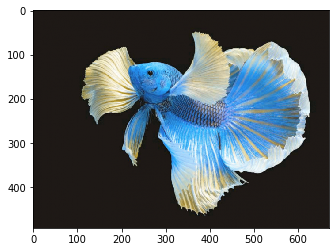

In [5]:
#don't forget it is in brg
plt.imshow(img)

In [6]:
#convert to hsv
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


In [7]:
#convert to pixels
pixels = np.float32(img_HSV.reshape(-1, 3))

In [8]:
def shift_h_remove(data, v_thresh, s_thresh):
    """Produces shifted H values for color segmentation and removed neutral tones
    Inputs: data - list of pixel H, S, V values one entry per pixel
    Outputs: H, H120, H240
    """
    shifted_colors = []
    for i in range(0,len(data)):
        H = data[i][0]
        s = data[i][1]
        v = data[i][2]
        V_thres = 255*v_thresh
        S_thres = 255*s_thresh
        if (v > V_thres and s > S_thres):
            if H >= 120:
                H120 = H - 120
            else:
                H120 = H + 60
            if H >= 60:
                H240 = H - 60
            else:
                H240 = H + 120
            shifted_colors.append([H, H120, H240, s, v])        
        else:
           pass
        
        
    return shifted_colors

In [9]:
pixels_shift = shift_h_remove(pixels, .25, .25)

In [750]:
pixels_shift[0]

[40.0, 100.0, 160.0, 126.0, 138.0]

In [751]:
len(pixels)

172800

In [752]:
len(pixels_shift)

145714

In [10]:
pixels_df = pd.DataFrame(pixels_shift, columns=['h','H120','H240','s','v'])

In [11]:
X_pixels = pixels_df[['h']]

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42, algorithm = 'full')
kmeans.fit(X_pixels)
image2show = kmeans.cluster_centers_[kmeans.labels_]

In [13]:
kmeans_df = pd.DataFrame(image2show, columns=['h'])

In [907]:
kmeans_df['label'] = kmeans.labels_

In [908]:
kmeans_df.groupby('label').mean()

,h
label,
0,36.933394
1,106.618328
2,49.042010
3,175.204285
4,8.638229
5,40.085832
6,67.061803
7,27.723581


In [909]:
kmeans_df.label.value_counts()

0    166020
5     78281
2     43180
1     31493
7     11450
4      9893
6      4935
3      2007
Name: label, dtype: int64

In [910]:
kmeans_top = kmeans_df[(kmeans_df['label'] == 5) | (kmeans_df['label'] == 14)| (kmeans_df['label'] == 0)| (kmeans_df['label'] == 17)| (kmeans_df['label'] == 16)| (kmeans_df['label'] == 3)| (kmeans_df['label'] == 11)| (kmeans_df['label'] == 12)| (kmeans_df['label'] == 8)]

In [911]:
kmeans_top.label.value_counts()

0    166020
5     78281
3      2007
Name: label, dtype: int64

In [14]:
X = kmeans_df[['h']]

In [15]:
predict_colors = hsv_knn.predict(X)

In [16]:
colors2 = np.array(np.unique(predict_colors, return_counts=True)).T

In [17]:
colors2

array([['Aussie Red Gold', 19594],
       ['Burnt Umber', 18595],
       ['Cerulean Blue Chromium', 5845],
       ['Manganese Blue Hue', 4852],
       ['Quinacridone Deep Gold', 9737],
       ['Quinacridone Sienna', 2921],
       ['Yellow Ochre', 9270]], dtype=object)

In [18]:
colors2df = pd.DataFrame(colors2, columns = ['name', 'count'])

In [19]:
colors2df.sort_values(by=['count'], ascending = False)

,name,count
0,Aussie Red Gold,19594
1,Burnt Umber,18595
4,Quinacridone Deep Gold,9737
6,Yellow Ochre,9270
2,Cerulean Blue Chromium,5845
3,Manganese Blue Hue,4852
5,Quinacridone Sienna,2921


In [889]:
kmeans.cluster_centers_

array([[ 43.30854256],
       [  7.68678839],
       [ 34.43389365],
       [ 17.48340492],
       [ 47.38060202],
       [  3.85151758],
       [ 39.99298131],
       [178.04347826]])

In [890]:
colors = np.array(np.unique(kmeans.labels_, return_counts=True)).T
print(colors)

[[     0 245629]
 [     1  90201]
 [     2  57468]
 [     3  17927]
 [     4 125178]
 [     5  61051]
 [     6 150598]
 [     7     23]]


In [861]:
kmeans.labels_

array([5, 5, 5, ..., 5, 5, 5], dtype=int32)

# Start HERE

In [327]:
hsv_knn2 = load('ds_h_knn_2.joblib')

In [20]:
predict_colors = hsv_knn.predict(X_pixels)

In [21]:
predict_colors

array(['Manganese Blue Hue', 'Manganese Blue Hue', 'Manganese Blue Hue',
       ..., 'Manganese Blue Hue', 'Manganese Blue Hue',
       'Manganese Blue Hue'], dtype=object)

In [22]:
colors = np.array(np.unique(predict_colors, return_counts=True)).T

In [23]:
colors

array([['Burnt Umber', 8727],
       ['Cadmium Yellow Medium Hue', 9],
       ['Cerulean Blue', 2],
       ['Cerulean Blue Chromium', 3131],
       ['Indian Yellow', 149],
       ['Manganese Blue Hue', 7442],
       ['Naples Yellow', 193],
       ['Nickel Azo Yellow', 2925],
       ['Organic Vermilion', 29],
       ['Perinone Orange', 959],
       ['Phthalo Blue Green Shade', 7],
       ['Phthalo Turquoise', 114],
       ['Prussian Blue', 1],
       ['Pyrrol Orange', 1384],
       ['Pyrrol Scarlet', 2],
       ['Quinacridone Burnt Scarlet', 99],
       ['Quinacridone Deep Gold', 8353],
       ['Quinacridone Gold', 8448],
       ['Quinacridone Sienna', 852],
       ['Raw Sienna', 9868],
       ['Raw Umber', 4676],
       ['Rich Green Gold', 1318],
       ['Sepia', 11146],
       ['Shadow Violet', 980]], dtype=object)

In [24]:
predictions = pd.DataFrame(colors, columns=["name","pixels"])

In [25]:
predictions.sort_values(by=['pixels'], ascending = False)

,name,pixels
22,Sepia,11146
19,Raw Sienna,9868
0,Burnt Umber,8727
17,Quinacridone Gold,8448
16,Quinacridone Deep Gold,8353
5,Manganese Blue Hue,7442
20,Raw Umber,4676
3,Cerulean Blue Chromium,3131
7,Nickel Azo Yellow,2925
13,Pyrrol Orange,1384
